# Model Training & Building

In this step, we are ready to do some experiments and select the best model for production use.

![Training](./images/02-Training.jpg)



## Training

**Input** : Register Data Set (ProductReview)

**Output** : Trained Model 

In [1]:
#%pip install nltk

## Case 1 - Local train on Computer Instance without Tracking
### 1. Load Dataset ProductReview

In [2]:
%matplotlib inline
import re
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import classification_report,plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from azureml.core.run import Run
import nltk
from sklearn.model_selection import GridSearchCV
from azureml.core import Workspace, Dataset
import matplotlib.pyplot as plt
from joblib import dump
from sklearn.feature_extraction.text import CountVectorizer

# Get workspace from run context
workspace = Workspace.from_config()




In [6]:
# Load Data
dataset = Dataset.get_by_name(workspace, name='ProductReview')
data = dataset.to_pandas_dataframe()[['overall', 'reviewText']]

### 2. Train model

In [7]:
import os
if not os.path.exists('models'):
    os.makedirs('models')

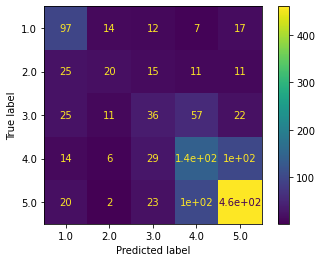

['./models/mnb.pkl']

In [8]:
# Prepare X & Y
Y = data.pop('overall').to_numpy()
X = data.pop('reviewText').to_numpy()
train_x, test_x, train_y, test_y = train_test_split(X,Y, test_size = 0.1, random_state=1)

# Fit vectorizer
vec = CountVectorizer()
fitted_train_data = vec.fit_transform(train_x)
fitted_test_data = vec.transform(test_x)

# Train a Naive Bayer model
model = MultinomialNB()
params = {'alpha': [1.0e-5, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]}

clf = GridSearchCV(model, params, scoring = "f1_macro", verbose=0, cv = 5)
clf_result = clf.fit(fitted_train_data, train_y)
pred = clf.predict(fitted_test_data)

plot_confusion_matrix(clf, fitted_test_data, test_y)  
plt.show()

# Save trained model
dump(vec, './models/vec.pkl')
dump(clf, './models/mnb.pkl')

## Case 2 - Local train on Computer Instance with tracking

In this demo, we will show how to train a model with tracking. AzureML tracks training with **Experiment** and **Runs**. 

In [10]:
import os
if not os.path.exists('train'):
    os.makedirs('train')

In [11]:
%%writefile train/train_2.py
# General libraries.
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import classification_report,plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from azureml.core.run import Run
from sklearn.model_selection import GridSearchCV
from azureml.core import Workspace, Dataset
import matplotlib.pyplot as plt
from joblib import dump
from sklearn.feature_extraction.text import CountVectorizer

run = Run.get_context()

# Get workspace from run context
workspace = run.experiment.workspace

# Load Data
dataset = Dataset.get_by_name(workspace, name='ProductReview')
data = dataset.to_pandas_dataframe()[['overall', 'reviewText']]

# Prepare X & Y
Y = data.pop('overall').to_numpy()
X = data.pop('reviewText').to_numpy()
train_x, test_x, train_y, test_y = train_test_split(X,Y, test_size = 0.1, random_state=1)


vec = CountVectorizer()
fitted_train_data = vec.fit_transform(train_x)
fitted_test_data = vec.transform(test_x)

model = MultinomialNB()
params = {'alpha': [1.0e-5, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]}

clf = GridSearchCV(model, params, scoring = "f1_macro", verbose=0, cv = 5)
clf_result = clf.fit(fitted_train_data, train_y)
run.log("Best alpha ",clf_result.best_estimator_.alpha)
pred = clf.predict(fitted_test_data)
run.log("F1", metrics.f1_score(test_y, pred, average='weighted'))

plot_confusion_matrix(clf, fitted_test_data, test_y)  
plt.savefig('confusion_matrix.png')
run.log_image(name='Confusion-Matrix', path='./confusion_matrix.png')

# Save trained model
dump(vec, './vec.pkl')
dump(clf, './mnb.pkl')
run.upload_file(name='vec.pkl', path_or_stream='./vec.pkl')
run.upload_file(name='mnb.pkl', path_or_stream='./mnb.pkl')

Writing train/train_2.py


In [13]:
import azureml.core
from azureml.core import Workspace, Experiment, Datastore, Environment
from azureml.widgets import RunDetails
from azureml.core import ScriptRunConfig
# Use a RunConfiguration to specify some additional requirements for this step.
from azureml.core.runconfig import RunConfiguration
from azureml.core.conda_dependencies import CondaDependencies

source_directory = './train'
script_name = 'train_2.py'

env = Environment.get(workspace=workspace, name="AzureML-sklearn-0.24-ubuntu18.04-py37-cpu")
training_step = ScriptRunConfig(source_directory=source_directory,
                      script=script_name,
                      compute_target='local', # local training
                      environment=env)

# init experiment
experiment = Experiment(workspace=workspace, name='MLOps-Workshop')

# submit experiment
run = experiment.submit(config=training_step)

# Stream running details
RunDetails(run).show()

Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class KubernetesCompute: This is an experimental class, and may change at any time. Plea

### List Experiment & Run result

In [15]:
exp = Experiment(workspace, 'MLOps-Workshop')

for r in Run.list(exp):
    if r.status == 'Completed':
        print(f"Run ID: {r.id}; F1: {r.get_metrics(name='F1')}")

Run ID: MLOps-Workshop_1646852775_10618a3c; F1: {'F1': 0.5834975414430202}
Run ID: MLOps-Workshop_1646852743_2c0cd649; F1: {'F1': 0.5834975414430202}
Run ID: e8cc9ed4-feea-490d-ad20-d95365174be3; F1: {}
Run ID: eadc9ff6-bc2b-4db7-98e6-61cc77c66a7c; F1: {}
Run ID: 7b517643-4773-4af0-891a-d324cd87b04f; F1: {}
Run ID: 1c39d5ba-4368-494b-8494-f3acb8f7e3fb; F1: {}
Run ID: c0dbb381-17bb-4774-a835-19491f3145b0; F1: {}
Run ID: 250547ba-b298-4cb0-b52d-3d4a06ced847; F1: {}
Run ID: a38f2372-eef2-4396-ac61-32db5c062c54; F1: {}
Run ID: 21cb57f2-bb40-43ad-a548-54e5d1599969; F1: {}


Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class KubernetesCompute: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class KubernetesCompute: This is an experimental class, and may change at any time. Plea

## Experiment Tracking

Experiment will be recorded in AzureML Experiments. Notice how the dataset is also recorded as input dataset, keeping the linearage of the data.

Under **Metrics** tab, the logged F1 score can be seen.

Under **Output + Logs** tab, users can find logs and uploaded files
![Experiment](./images/02-TrainingOutput.jpg)